In [1]:
#Get the iWidget stuff
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os
import sys

sys.path.append('/home/michael/jupyter/local-packages')

# Get my Utilities (localUtilities)
from localUtilities import dateUtils, ibPyUtils, configIB 

import numpy as np
import pandas as pd
import datetime
import random
import itertools
import math

# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

#interactive Shell to see variables outside of print() function - 
#  if this is on one can suppress output by adding a ';' at the end of line 
#   not 100% clear which variables this supresses 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Doc is here: https://ib-insync.readthedocs.io/readme.html
from ib_insync import *
util.startLoop()

ib = IB()
# Connect to IB Gateway / Paper Trade 4002 
#            TWS        / Paper Trade 7495
ib.connect('127.0.0.1', configIB.IB_PAPER_TRADE_PORT, clientId=3)

<IB connected to 127.0.0.1:4002 clientId=3>

In [2]:
#See if connected 
ib.isConnected()

True

In [ ]:
#disconnect
ib.disconnect()

In [3]:

theStock = 'SWKS'
contract = Stock(theStock, 'SMART', 'USD')

earningsDate4 = ['05/02/2019','04:00PM']
earningsDate3 = ['02/05/2019','04:00PM']
earningsDate2 = ['11/08/2018','04:00PM']
earningsDate1 = ['07/19/2018','04:00PM']

# Create a list of list w/ Earning String Dates
earningDates = [earningsDate1, earningsDate2, earningsDate3, earningsDate4]
# Create a list of Earning datetime Dates from earningDates Strings
earningDateTime = [datetime.datetime.strptime(aDate[0]+aDate[1], '%m/%d/%Y%I:%M%p') for aDate in earningDates]
# Put in Panda DataFrame
earningsCalendar = pd.DataFrame({'EarningStrDate': earningDates,
                                 'EarningDateTime': earningDateTime})

In [4]:

# # add daysAroundEarnings Days forward - this will be used to count back and plot time
# # durationString,The amount of time (or Valid Duration String units) to go back from the request's given end date and time.

# add X(daysPassEarnings) Days forward past earnings - this will be used to count back
daysPassEarnings = 60

# How far back from daysPassEarnings
durationStrDays = '90 D'
# Bar size
setBarSizeSetting = '1 day'

#create time series panda dataframes from IB
earningsPastStock = []
earningsPastImpVol=[]

for earnData in range(0, len(earningsCalendar)):
        earningsPastStock.append(util.df(ib.reqHistoricalData(contract, endDateTime=earningsCalendar['EarningDateTime'][earnData]
                                                              +datetime.timedelta(days=daysPassEarnings),  
                                                              durationStr=durationStrDays,barSizeSetting=setBarSizeSetting, 
                                                              whatToShow='TRADES', useRTH=True)))
        earningsPastImpVol.append(util.df(ib.reqHistoricalData(contract, endDateTime=earningsCalendar['EarningDateTime'][earnData]
                                                               +datetime.timedelta(days=daysPassEarnings), 
                                                               durationStr=durationStrDays,barSizeSetting=setBarSizeSetting, 
                                                               whatToShow='OPTION_IMPLIED_VOLATILITY', useRTH=True)))


Text(0.5, 1.0, 'SWKS Stock price  / Earnings Date: 07/19/2018')

Text(0.5, 0, 'time')

Text(0, 0.5, 'Stock Price @Close')

Text(0, 0.5, 'Implied Volatility @Close')

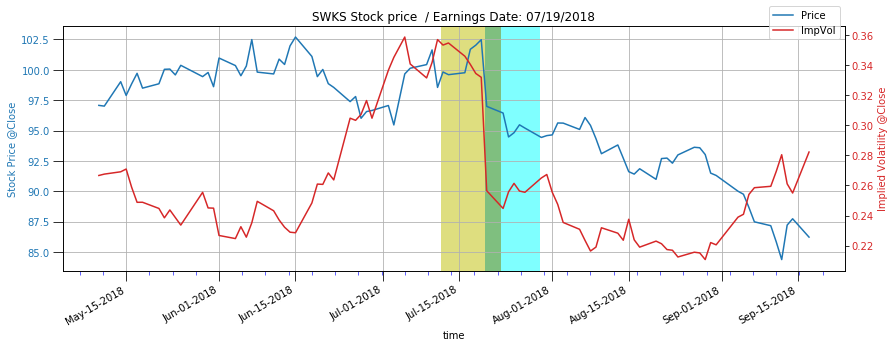

TypeError: type Series doesn't define __trunc__ method

In [6]:
colorStock = 'tab:blue'
colorImpVol = 'tab:red'
xLabel = 'time'
yLabelStock = 'Stock Price @Close';
yLabelImpVol = 'Implied Volatility @Close';
ax1LegendLabel = "Price"
ax2LegendLabel = "ImpVol"

locator = mdates.AutoDateLocator(minticks=5, maxticks=15)
formatter = mdates.ConciseDateFormatter(locator)
myFmt = DateFormatter("%b-%d-%Y")


for earn in range(0, len(earningsCalendar)): # for all the dates in earningsCalendar
    fig, ax1 = plt.subplots(figsize=(14,5)); # single Plot

    theTitle = theStock + " Stock price "+ " / Earnings Date: " + earningsCalendar.EarningStrDate.at[earn][0];
    ax1.set_title(theTitle);

    ax1.set_xlabel(xLabel);
    ax1.set_ylabel(yLabelStock, color=colorStock);
    ax1.plot(earningsPastStock[earn]['date'], earningsPastStock[earn]['close'], color=colorStock, label=ax1LegendLabel);
    ax1.tick_params(axis='y', labelcolor=colorStock);
    ax1.grid(True);

    # instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx();
    ax2.set_ylabel(yLabelImpVol, color=colorImpVol)  # we already handled the x-label with ax1
    ax2.plot(earningsPastImpVol[earn]['date'] ,earningsPastImpVol[earn]['close'], color=colorImpVol, label=ax2LegendLabel)
    ax2.tick_params(axis='y', labelcolor=colorImpVol)

    #build Legend for 2 Xaxis
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(1.0, 1.1))

    #set up Major/Minor xAxis 
    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(formatter)

    # Format xAxis Date
    ax1.xaxis.set_major_formatter(myFmt)
    ax1.tick_params(which='major', length=10)
    ax1.tick_params(which='minor', length=4, color='b')
    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    
    ax1.axvspan(mdates.date2num(earningsCalendar['EarningDateTime'][earn]),
                mdates.date2num(earningsCalendar['EarningDateTime'][earn]+datetime.timedelta(days=3)),
                facecolor='g', alpha=0.5)
    ax1.axvspan(mdates.date2num(earningsCalendar['EarningDateTime'][earn]),
                mdates.date2num(earningsCalendar['EarningDateTime'][earn]-datetime.timedelta(days=8)),
                facecolor='y', alpha=0.5)
    ax1.axvspan(mdates.date2num(earningsCalendar['EarningDateTime'][earn]+datetime.timedelta(days=3)),
                mdates.date2num(earningsCalendar['EarningDateTime'][earn]+datetime.timedelta(days=10)),
                facecolor='aqua', alpha=0.5)

    fig.autofmt_xdate()
    plt.show()
    
    #=========================================================================================================
#     #get earning date
#     print(earningsCalendar.loc[:,:])
#     print(earningsCalendar.EarningDateTime[earn])

    # recreate index as the 'date' column 
    ePS2 = earningsPastStock[earn].set_index("date", drop=False)
    ePS2.index = pd.to_datetime(ePS2.index)

    onEarningDate = earningsCalendar.EarningDateTime[earn].date()
    onEarningDatePast = onEarningDate - datetime.timedelta(days=15)
    onEarningDateForward = onEarningDate + datetime.timedelta(days=15)

    # Create new dataframe from old // old[['A', 'C', 'D']].copy()
    # Create a new df and set index to date
    onEarningDatePastdf=(ePS2.loc[onEarningDatePast:onEarningDateForward,['date','close']].copy()).set_index("date", drop=False)

    # Let’s add a new column ‘Percentage’ where entry at each index will be calculated by the values in other columns at that index i.e.
    # dfObj['Percentage'] =  (dfObj['Marks'] / dfObj['Total'] ) * 100
    x=earningsCalendar.EarningDateTime[earn].date()
    onEarningDatePastdf['earningDayPriceDelta'] = round((onEarningDatePastdf['close'] - ePS2.close.at[x]),2)
    onEarningDatePastdf['earningDayPercentDelta'] = round(100-((ePS2.close.at[x]/onEarningDatePastdf['close'])*100),2)
    # onEarningDatePastdf.earningDayPercentDelta.max()
    # onEarningDatePastdf.earningDayPriceDelta.max()
    print('Earning Price Max:  ', onEarningDatePastdf.earningDayPriceDelta.max())
    print('Earning Price Min:  ', onEarningDatePastdf.earningDayPriceDelta.min())
    print('Earning Price Max % Delta:  ', onEarningDatePastdf.earningDayPercentDelta.max())
    print('Earning Price Min % Delta:  ', onEarningDatePastdf.earningDayPercentDelta.min())
    onEarningDatePastdf

    #-----------------------------------
    # recreate index as the 'date' column 
    ePIV2 = earningsPastImpVol[earn].set_index("date", drop=False)
    ePIV2.index = pd.to_datetime(ePIV2.index)

    # Create new dataframe from old // old[['A', 'C', 'D']].copy()
    # Create a new df and set index to date
    onEarningDatePastIVdf=(ePIV2.loc[onEarningDatePast:onEarningDateForward,['date','close']].copy()).set_index("date", drop=False)

    onEarningDatePastIVdf['earningDayIVPriceDelta'] = round(onEarningDatePastIVdf['close'] - ePIV2.close.at[x],2)
    onEarningDatePastIVdf['earningDayIVPercentDelta'] = round(100-round(((ePIV2.close.at[x]/onEarningDatePastIVdf['close'])*100),2))
    print('Earning ImpVol Max:  ', onEarningDatePastIVdf.earningDayIVPriceDelta.max())
    print('Earning ImpVol Min:  ', onEarningDatePastIVdf.earningDayIVPriceDelta.min())
    print('Earning ImpVol Max % Delta:  ', onEarningDatePastIVdf.earningDayIVPercentDelta.max())
    print('Earning ImpVol Min % Delta:  ', onEarningDatePastIVdf.earningDayIVPercentDelta.min())
    onEarningDatePastIVdf

